In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re 
from collections import Counter

import ast
import warnings
warnings.filterwarnings('ignore')

# Models' average results

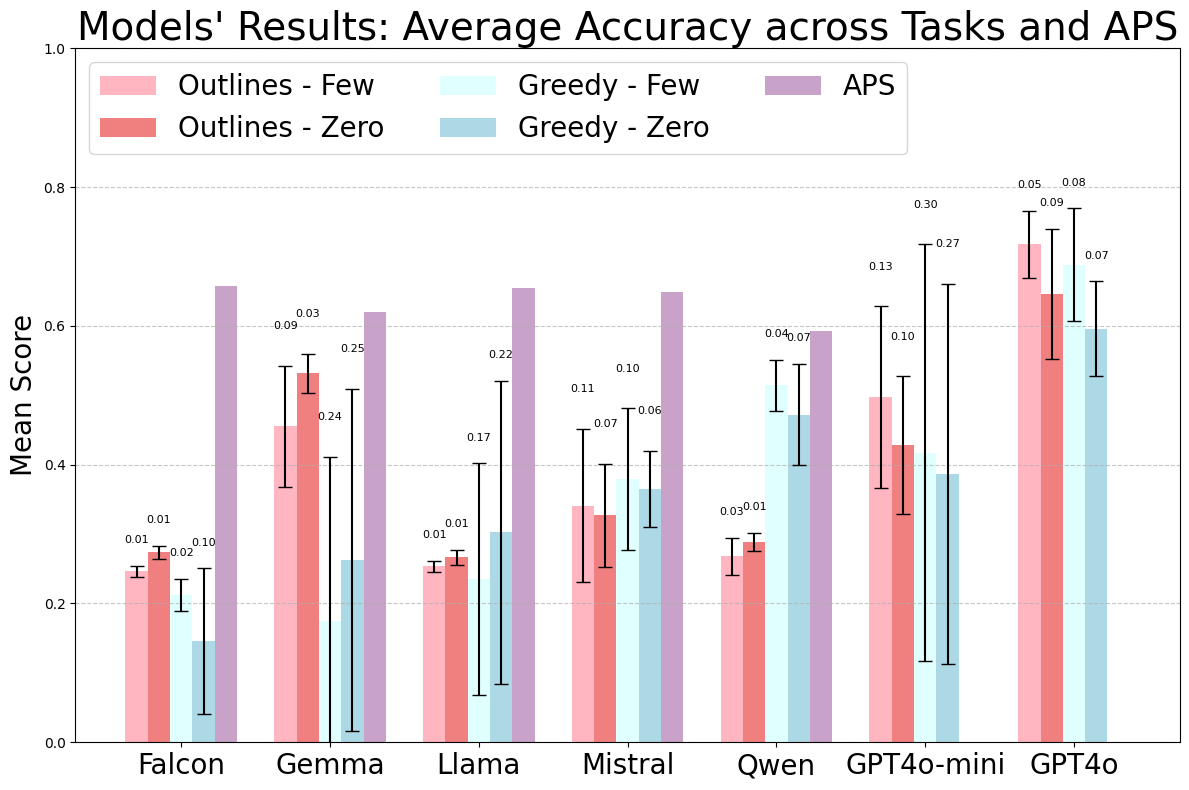

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['Falcon', 'Gemma', 'Llama', 'Mistral', 'Qwen', 'GPT4o-mini', 'GPT4o']

# Updated values

# Outlines (Few)
media_outlines_few = [0.2461, 0.4552, 0.2535, 0.3412, 0.2681, 0.4976, 0.7174]
std_outlines_few = [0.0080, 0.0870, 0.0084, 0.1107, 0.0266, 0.1308, 0.0480]

# Outlines (Zero)
media_outlines_zero = [0.2740, 0.5318, 0.2669, 0.3270, 0.2889, 0.4281, 0.6458]
std_outlines_zero = [0.0092, 0.0284, 0.0109, 0.0746, 0.0126, 0.0990, 0.0938]

# Greedy (Few)
media_greedy_few = [0.2123, 0.1753, 0.2347, 0.3793, 0.5142, 0.4171, 0.6883]
std_greedy_few = [0.0229, 0.2364, 0.1672, 0.1019, 0.0366, 0.3005, 0.0810]

# Greedy (Zero)
media_greedy_zero = [0.1458, 0.2630, 0.3027, 0.3648, 0.4721, 0.3868, 0.5959]
std_greedy_zero = [0.1047, 0.2468, 0.2184, 0.0552, 0.0730, 0.2741, 0.0681]

# AP Scores (Overall)
ap_scores = [0.658019, 0.620283, 0.654481, 0.648585, 0.59316, None, None]  # No AP scores for GPT4o-mini and GPT4o

# Bar plot preparation
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars and positions
bar_width = 0.15
index = np.arange(len(models))

# Create the bars for Outlines and Greedy with Few and Zero
bars_outlines_few = ax.bar(index - 2*bar_width, media_outlines_few, bar_width, yerr=std_outlines_few, 
                            label='Outlines - Few', capsize=5, color='#FFB6C1', edgecolor='none')
bars_outlines_zero = ax.bar(index - bar_width, media_outlines_zero, bar_width, yerr=std_outlines_zero, 
                            label='Outlines - Zero', capsize=5, color='#F08080', edgecolor='none')

bars_greedy_few = ax.bar(index, media_greedy_few, bar_width, yerr=std_greedy_few, 
                          label='Greedy - Few', capsize=5, color='#E0FFFF', edgecolor='none')
bars_greedy_zero = ax.bar(index + bar_width, media_greedy_zero, bar_width, yerr=std_greedy_zero, 
                          label='Greedy - Zero', capsize=5, color='#ADD8E6', edgecolor='none')

# AP Score bars without error bars
bars_ap_score = ax.bar(index + 2*bar_width, [score if score is not None else 0 for score in ap_scores], 
                       bar_width, label='APS', color='#C8A2C8', edgecolor='none')

# Labels and titles
ax.set_ylabel('Mean Score', fontsize=20)  
ax.set_title('Models\' Results: Average Accuracy across Tasks and APS', fontsize=28)  
ax.set_xticks(index)
ax.set_xticklabels(models, fontsize=20)  

# Set the y-axis scale to range from 0 to 1
ax.set_ylim(0, 1)

# Add grid to the plot
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the legend
ax.legend(ncol=3, fontsize=20, loc='upper left')

# Add standard deviation labels above the bars
for i in range(len(models)):
    y_offset = 0.03 if i % 2 == 0 else 0.05  
    # Outlines - Few
    ax.text(bars_outlines_few[i].get_x() + bars_outlines_few[i].get_width() / 2, 
            bars_outlines_few[i].get_height() + std_outlines_few[i] + y_offset, 
            f"{std_outlines_few[i]:.2f}", ha='center', va='bottom', fontsize=8)  
    
    # Outlines - Zero
    ax.text(bars_outlines_zero[i].get_x() + bars_outlines_zero[i].get_width() / 2, 
            bars_outlines_zero[i].get_height() + std_outlines_zero[i] + y_offset, 
            f"{std_outlines_zero[i]:.2f}", ha='center', va='bottom', fontsize=8)
    
    # Greedy - Few
    ax.text(bars_greedy_few[i].get_x() + bars_greedy_few[i].get_width() / 2, 
            bars_greedy_few[i].get_height() + std_greedy_few[i] + y_offset, 
            f"{std_greedy_few[i]:.2f}", ha='center', va='bottom', fontsize=8)
    
    # Greedy - Zero
    ax.text(bars_greedy_zero[i].get_x() + bars_greedy_zero[i].get_width() / 2, 
            bars_greedy_zero[i].get_height() + std_greedy_zero[i] + y_offset, 
            f"{std_greedy_zero[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Save the plot with high resolution
plt.tight_layout()
plt.savefig('high_res_plot.png', dpi=300)

# Show the plot
plt.show()


# Get ratings and normalized perplexity

In [5]:
# Define the file path for human ratings dataset
human_ratings_path = "../../data/explica/explica_freq_4800.tsv"

# Load the human ratings dataset into a pandas DataFrame
human_ratings = pd.read_csv(human_ratings_path, sep=",")
# Sort the dataset based on multiple columns to ensure a consistent order
# Sorting by 'pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', and 'tested_order'
# helps in maintaining consistency for further analysis
human_ratings = human_ratings.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order'])



In [6]:
import pandas as pd
import numpy as np

def get_ratings_and_perpl(desc, _dict, distribution, human_ratings):
    """
    Processes model outputs and human ratings to compute accuracy distributions and perplexity scores.
    
    Parameters:
    - desc (str): Description of the task (e.g., "acc_few", "perpl", etc.).
    - _dict (dict): Dictionary mapping model names to CSV file paths.
    - distribution (dict): Dictionary to store computed accuracy and perplexity distributions.
    - human_ratings (DataFrame): DataFrame containing human-generated ratings for evaluation.
    
    Returns:
    - dict: Updated distribution dictionary containing model accuracies and perplexity measures.
    """

    print(f"**** Processing Task: {desc}")

    # Iterate through each model and its corresponding CSV path
    for model, path in _dict.items():
        print(f"******* Processing Model: {model}")

        # Read the model's prediction file into a DataFrame
        df_curr = pd.read_csv(path, sep="\t")

        # Construct a key based on task description and model name
        key = f"{desc}_{model}"

        # Initialize distribution dictionaries based on the task type
        if "acc" in desc:  # For accuracy-related tasks
            distribution[key+"_greedy"] = dict()  # Stores greedy predictions
            distribution[key+"_outlines"] = dict()  # Stores generated outlines
        elif "perpl" in desc:  # For perplexity-related tasks
            distribution["norm_"+key] = dict()  # Normalized perplexity scores
            distribution[key] = dict()  # Raw perplexity scores
        else:  # Other tasks
            distribution[key] = dict()

        # Sort DataFrame by multiple columns to ensure consistent order
        df_curr = df_curr.sort_values(by=['pair_id', 'Sentence_A', 'Sentence_B', 'relation', 'order', 'conn_in_list'])

        # Rename certain columns to make them more explicit
        if "relation" in df_curr and "order" in df_curr and "conn_in_list" in df_curr:
            df_curr["tested_relation"] = df_curr["relation"]
            del df_curr["relation"]
            df_curr["tested_order"] = df_curr["order"]
            del df_curr["order"]
            df_curr["tested_connective"] = df_curr["conn_in_list"]
            del df_curr["conn_in_list"]

        # Merge model results with human ratings based on key attributes
        df_curr_with_max = pd.merge(
            df_curr, 
            human_ratings[['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective', 
                           'order_human', 'relation_human', 'condition_human', 'human_preferred_connective_unrel']],
            how='left', 
            on=['pair_id', 'Sentence_A', 'Sentence_B', 'tested_relation', 'tested_order', 'tested_connective']
        )

        # Store the human-chosen connective for further evaluation
        df_curr_with_max['human_chosen_connective'] = df_curr_with_max['human_preferred_connective_unrel']

        # Process perplexity scores if the task involves perplexity
        if "perpl" in desc:
            perplexity = np.array([float(x) for x in df_curr_with_max["perplexity"].tolist()])

            # Compute the reciprocal of perplexity for normalization
            inverted_perplexity = 1 / perplexity

            # Normalize perplexity values within the range [1, 10]
            min_inv_perplexity = np.min(inverted_perplexity)
            max_inv_perplexity = np.max(inverted_perplexity)
            norm_perpl = 1 + ((inverted_perplexity - min_inv_perplexity) / 
                              (max_inv_perplexity - min_inv_perplexity)) * (10 - 1)
            
            df_curr_with_max["norm_perpl"] = norm_perpl

        # The model's predicted labels are stored in this column
        column_model_result_name = "model_chosen_connective"

        # Create subsets based on human annotations for different relation types
        df_human_gt_caus_AB = df_curr_with_max[(df_curr_with_max['order_human'] == "A,B") & 
                                               (df_curr_with_max['relation_human'] == "Causal")]
        df_human_gt_temp_AB = df_curr_with_max[(df_curr_with_max['order_human'] == "A,B") & 
                                               (df_curr_with_max['relation_human'] == "Temporal")]
        df_human_gt_caus_BA = df_curr_with_max[(df_curr_with_max['order_human'] == "B,A") & 
                                               (df_curr_with_max['relation_human'] == "Causal")]
        df_human_gt_temp_BA = df_curr_with_max[(df_curr_with_max['order_human'] == "B,A") & 
                                               (df_curr_with_max['relation_human'] == "Temporal")]
        df_human_gt_unrel = df_curr_with_max[(df_curr_with_max['order_human'] == "none") & 
                                             (df_curr_with_max['relation_human'] == "no_rel")]

        # Combine all data subsets into one DataFrame
        total = pd.concat([df_human_gt_caus_AB, df_human_gt_temp_AB, df_human_gt_caus_BA, df_human_gt_temp_BA, df_human_gt_unrel])

        # Create a dictionary to store results for different categories
        dfs = {
        "Caus. Ic." : df_human_gt_caus_AB,
        "Temp. Ic." : df_human_gt_temp_AB,
        "Caus. a.Ic." : df_human_gt_caus_BA,
        "Temp. a.Ic" : df_human_gt_temp_BA,
        "Unrel." : df_human_gt_unrel,
        "All": total
        }

        # Iterate through the different relation types and store results
        for k, v in dfs.items():
            if "human" not in distribution:
                distribution["human"] = dict()
            if k not in distribution["human"]:
                distribution["human"][k] = v["accept_average_vote"].tolist()

            if "perpl" in desc:
                # Store normalized and raw perplexity scores
                distribution["norm_"+key][k] = v["norm_perpl"].tolist()
                distribution[key][k] = v["perplexity"].tolist()

            if "acc" in desc:
                # Store accuracy results for greedy and outline-generated answers
                distribution[key+"_greedy"][k] = v["answer_greedy_cleaned"].tolist()
                distribution[key+"_outlines"][k] = v["generated_answer_outlines"].tolist()

    return distribution


In [7]:
distribution = dict()

acc_few_dict = {"falcon" : "../../data/res/acceptability/fewshot/accept_res_outlines_falcon-7b-instruct.tsv",
"gemma" : "../../data/res/acceptability/fewshot/accept_res_outlines_gemma-2-9b-it.tsv",
"gpt4omini" : "../../data/res/acceptability/fewshot/accept_res_outlines_gpt-4o-mini_few.tsv",
"gpt4o" : "../../data/res/acceptability/fewshot/accept_res_outlines_gpt-4o_few.tsv",
"llama" : "../../data/res/acceptability/fewshot/accept_res_outlines_Meta-Llama-3.1-8B-Instruct.tsv",
"mistral" : "../../data/res/acceptability/fewshot/accept_res_outlines_Mistral-7B-Instruct-v0.3.tsv",
"qwen" : "../../data/res/acceptability/fewshot/accept_res_outlines_Qwen2.5-7B-Instruct.tsv" }

distribution = get_ratings_and_perpl("acc_few", acc_few_dict, distribution, human_ratings)



###########*******

acc_zero_dict = {"falcon" : "../../data/res/acceptability/zeroshot/accept_res_outlines_falcon-7b-instruct.tsv",
"gemma" : "../../data/res/acceptability/zeroshot/accept_res_outlines_gemma-2-9b-it.tsv",
"gpt4omini" : "../../data/res/acceptability/zeroshot/accept_res_outlines_gpt-4o-mini_zero.tsv",
"gpt4o" : "../../data/res/acceptability/zeroshot/accept_res_outlines_gpt-4o_zero.tsv",
"llama" : "../../data/res/acceptability/zeroshot/accept_res_outlines_Meta-Llama-3.1-8B-Instruct.tsv",
"mistral" : "../../data/res/acceptability/zeroshot/accept_res_outlines_Mistral-7B-Instruct-v0.3.tsv",
"qwen" : "../../data/res/acceptability/zeroshot/accept_res_outlines_Qwen2.5-7B-Instruct.tsv" }

distribution = get_ratings_and_perpl("acc_zero", acc_zero_dict, distribution, human_ratings)




###########*******

perpl_dict = {
    "falcon": "../../data/res/perplexity/falcon-7b-instruct.csv",
    "gemma": "../../data/res/perplexity/gemma-2-9b-it.csv",
    "llama": "../../data/res/perplexity/Meta-Llama-3.1-8B-Instruct.csv",
    "mistral": "../../data/res/perplexity/Mistral-7B-Instruct-v0.3.csv",
    "qwen": "../../data/res/perplexity/Qwen2.5-7B-Instruct.csv"
}


distribution = get_ratings_and_perpl("perpl", perpl_dict, distribution, human_ratings)



**** Processing Task: acc_few
******* Processing Model: falcon
******* Processing Model: gemma
******* Processing Model: gpt4omini
******* Processing Model: gpt4o
******* Processing Model: llama
******* Processing Model: mistral
******* Processing Model: qwen
**** Processing Task: acc_zero
******* Processing Model: falcon
******* Processing Model: gemma
******* Processing Model: gpt4omini
******* Processing Model: gpt4o
******* Processing Model: llama
******* Processing Model: mistral
******* Processing Model: qwen
**** Processing Task: perpl
******* Processing Model: falcon
******* Processing Model: gemma
******* Processing Model: llama
******* Processing Model: mistral
******* Processing Model: qwen


# Distribution in boxplots

In [8]:
model_to_plot = ["human", "acc_few_gpt4o_greedy","acc_zero_gemma_greedy", "norm_perpl_falcon" ]

distribution_to_plot = dict()
for m in model_to_plot:
    distribution_to_plot[m] = dict()
    for cat in distribution[m]:
        if "perpl" in m or "human" in m:
            distribution_to_plot[m][cat] = distribution[m][cat]
            continue
        distribution_to_plot[m][cat] = []
        for value in distribution[m][cat]:
            if value>0:
                distribution_to_plot[m][cat].append(value)
            else:
                continue

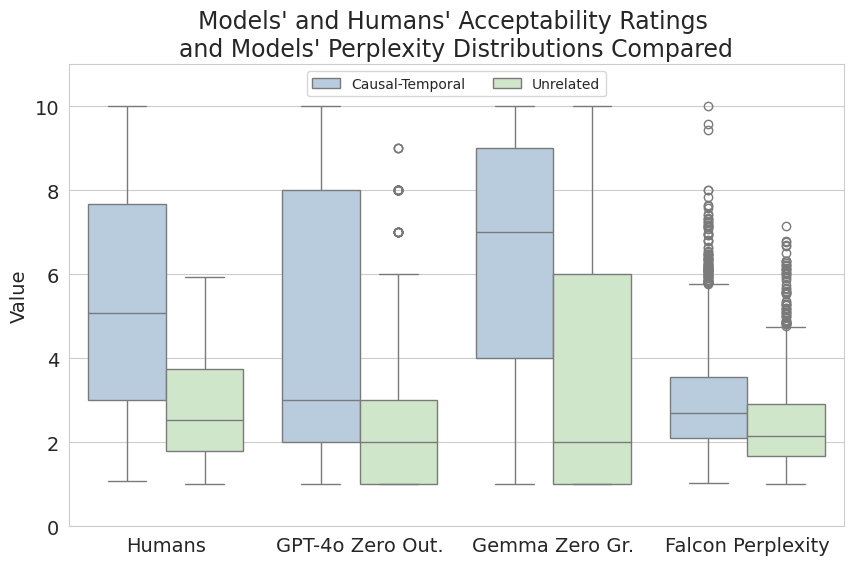

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a light background style
sns.set_style("whitegrid")

# Define light colors for the box plots
colors = ["#B3CDE3", "#CCEBC5"]  # Light pastel colors for each dataset

# Define selected models
models = {
    'Humans': 'human',
    'GPT-4o Zero Out.': 'acc_few_gpt4o_greedy',
    'Gemma Zero Gr.': 'acc_zero_gemma_greedy',
    'Falcon Perplexity': 'norm_perpl_falcon'
}

categories = ["Caus. Ic.", "Temp. Ic.", "Caus. a.Ic.", "Temp. a.Ic", "Unrel."]

data = []

#distribution_to_plot = distribution # COMMENTA PER VIZ SENZA ERRORI

# First dataset (Causality & Temporal Pairs)
for model_name, model_key in models.items():
    values = distribution_to_plot[model_key]
    
    for category in categories[:-1]:  # Excluding 'Unrelated'
        data.extend([(model_name, 'Causal-Temporal', val) for val in values[category]])

# Second dataset (Unrelated)
for model_name, model_key in models.items():
    values = distribution_to_plot[model_key]
    
    data.extend([(model_name, 'Unrelated', val) for val in values['Unrel.']])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Model', 'Category', 'Value'])

# Create the grouped boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Value', hue='Category', data=df, palette=colors)

# Increase font sizes by 20%
plt.title('Models\' and Humans\' Acceptability Ratings \nand Models\' Perplexity Distributions Compared', fontsize=17)
plt.ylabel('Value', fontsize=14)
plt.xticks(fontsize=14) 
plt.xlabel("")
plt.yticks(range(0, 12, 2), fontsize=14)  # Set y-axis limits from 0 to 11, showing even numbers
plt.ylim(0, 11)  # Ensure y-axis limit is correctly set #METTI QUESTO PER VIZ SENZA ERRORI
#plt.ylim(-2, 11)
plt.legend(title="Category", fontsize=12)  # Increase legend size
plt.legend(loc='upper center', ncols = 2)

# Show the plot
plt.show()


# Compute correlation 

## Human ratings and prompting tasks

### Overall

In [29]:
import scipy.stats
couples = []
models = list(distribution.keys())
for (model1, model2) in combinations(range(len(models)), 2):
    model1_name = models[model1]
    model2_name = models[model2]
    if "human" == models[model2]:
        model2_name = model1_name
        model1_name = "human"
    if "few" in model2_name:
        continue
    if "human" in model1_name and "zero" in model2_name:
        couples.append((model1_name, model2_name))
    


In [30]:

df_corr = pd.DataFrame()

model1 = []
model2 = []
corr = []
pvalue = []
for c1, c2 in couples:
    #for category in categories:
    res = scipy.stats.spearmanr(distribution[c1]["All"], distribution[c2]["All"])
    corr.append(f"{round(res.statistic, 2)} ({round(res.pvalue, 3)})")
    #pvalue.append(round(res.pvalue, 4))
    model1.append(c1)
    model2.append(c2)
     

df_corr['model1'] = model1
df_corr['model2'] = model2
df_corr['corr'] = corr
#df_corr['pvalue'] = pvalue

df_corr

,model1,model2,corr
0,human,acc_zero_falcon_greedy,0.05 (0.001)
1,human,acc_zero_falcon_outlines,0.0 (0.784)
2,human,acc_zero_gemma_greedy,0.65 (0.0)
3,human,acc_zero_gemma_outlines,0.55 (0.0)
4,human,acc_zero_gpt4omini_greedy,0.66 (0.0)
5,human,acc_zero_gpt4omini_outlines,0.38 (0.0)
6,human,acc_zero_gpt4o_greedy,0.46 (0.0)
7,human,acc_zero_gpt4o_outlines,0.77 (0.0)
8,human,acc_zero_llama_greedy,0.47 (0.0)
9,human,acc_zero_llama_outlines,0.05 (0.002)


### Categories

In [28]:
df_corr = pd.DataFrame()


categories = ["Caus. Ic.", "Temp. Ic.", "Caus. a.Ic.", "Temp. a.Ic", "Unrel.", "All"]

# Creating a dictionary to map model names to their "_gr" or "_out" versions

model_name_mapping = {
    "acc_few_falcon_greedy": "falcon_gr",
    "acc_few_falcon_outlines": "falcon_out",
    "acc_few_gemma_greedy": "gemma_gr",
    "acc_few_gemma_outlines": "gemma_out",
    "acc_few_gpt4omini_greedy": "gpt4o-mini_gr",
    "acc_few_gpt4omini_outlines": "gpt4o-mini_out",
    "acc_few_gpt4o_greedy": "gpt4o_gr",
    "acc_few_gpt4o_outlines": "gpt4o_out",
    "acc_few_llama_greedy": "llama_gr",
    "acc_few_llama_outlines": "llama_out",
    "acc_few_mistral_greedy": "mistral_gr",
    "acc_few_mistral_outlines": "mistral_out",
    "acc_few_qwen_greedy": "qwen_gr",
    "acc_few_qwen_outlines": "qwen_out",
    "acc_zero_falcon_greedy": "falcon_gr",
    "acc_zero_falcon_outlines": "falcon_out",
    "acc_zero_gemma_greedy": "gemma_gr",
    "acc_zero_gemma_outlines": "gemma_out",
    "acc_zero_gpt4omini_greedy": "gpt4o-mini_gr",
    "acc_zero_gpt4omini_outlines": "gpt4o-mini_out",
    "acc_zero_gpt4o_greedy": "gpt4o_gr",
    "acc_zero_gpt4o_outlines": "gpt4o_out",
    "acc_zero_llama_greedy": "llama_gr",
    "acc_zero_llama_outlines": "llama_out",
    "acc_zero_mistral_greedy": "mistral_gr",
    "acc_zero_mistral_outlines": "mistral_out",
    "acc_zero_qwen_greedy": "qwen_gr",
    "acc_zero_qwen_outlines": "qwen_out"
}


model1 = []
model2 = []
corr = []
pvalue = []
cat_list = []
for c1, c2 in couples:
    for category in categories:
        res = scipy.stats.spearmanr(distribution[c1][category], distribution[c2][category])
        corr.append(f"{round(res.statistic, 2)} ({round(res.pvalue, 3)})")
        cat_list.append(category)
        model2.append(model_name_mapping[c2])
     

df_corr['model2'] = model2
df_corr['category'] = cat_list
df_corr['corr'] = corr

df =df_corr
print(display(df))

human acc_zero_falcon_greedy
human acc_zero_falcon_outlines
human acc_zero_gemma_greedy
human acc_zero_gemma_outlines
human acc_zero_gpt4omini_greedy
human acc_zero_gpt4omini_outlines
human acc_zero_gpt4o_greedy
human acc_zero_gpt4o_outlines
human acc_zero_llama_greedy
human acc_zero_llama_outlines
human acc_zero_mistral_greedy
human acc_zero_mistral_outlines
human acc_zero_qwen_greedy
human acc_zero_qwen_outlines


,model2,category,corr
0,falcon_gr,Caus. Ic.,0.04 (0.2)
1,falcon_gr,Temp. Ic.,-0.07 (0.035)
2,falcon_gr,Caus. a.Ic.,0.04 (0.215)
3,falcon_gr,Temp. a.Ic,0.09 (0.023)
4,falcon_gr,Unrel.,0.05 (0.049)
...,...,...,...
79,qwen_out,Temp. Ic.,0.04 (0.233)
80,qwen_out,Caus. a.Ic.,0.06 (0.065)
81,qwen_out,Temp. a.Ic,0.03 (0.413)
82,qwen_out,Unrel.,-0.03 (0.312)


None


In [38]:
import numpy as np
import pandas as pd

def create_bar_data(df):
    """
    Creates a dictionary with model2 as keys and lists of correlation values
    grouped by categories from the given dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with columns ['model1', 'model2', 'category', 'corr']

    Returns:
        dict: Dictionary with 'model2' as keys and correlation lists grouped by category.
    """
    # Extract unique models from 'model2' in the given order
    model2_order = [
        "falcon_gr", "falcon_out", "gemma_gr", "gemma_out", "gpt4o-mini_gr", "gpt4o-mini_out",
        "gpt4o_gr", "gpt4o_out", "llama_gr", "llama_out", "mistral_gr", "mistral_out",
        "qwen_gr", "qwen_out"
    ]

    # Extract unique categories
    categories = df["category"].unique()

    # Initialize the dictionary
    bar_data = {"model2": model2_order}

    # Iterate over categories to fill correlation lists
    for category in categories:
        bar_data[category] = []

        for model in model2_order:
            # Find the correlation for the given model and category
            corr_value = df[(df["model2"] == model) & (df["category"] == category)]["corr"]
            
            # Append correlation value or NaN if not found
            if not corr_value.empty:
                bar_data[category].append(corr_value.values[0])
            else:
                bar_data[category].append(np.nan)  # Use NaN for missing values

    return bar_data



# Generate the bar_data dictionary
bar_data_output = create_bar_data(df)


In [39]:
# Convert to DataFrame
df_bar = pd.DataFrame(bar_data_output).sort_values('All', ascending=False)

print(display(df_bar))


,model2,Caus. Ic.,Temp. Ic.,Caus. a.Ic.,Temp. a.Ic,Unrel.,All
7,gpt4o_out,0.82 (0.0),0.8 (0.0),0.76 (0.0),0.69 (0.0),0.59 (0.0),0.77 (0.0)
4,gpt4o-mini_gr,0.65 (0.0),0.71 (0.0),0.6 (0.0),0.48 (0.0),0.5 (0.0),0.66 (0.0)
2,gemma_gr,0.63 (0.0),0.61 (0.0),0.7 (0.0),0.58 (0.0),0.44 (0.0),0.65 (0.0)
12,qwen_gr,0.44 (0.0),0.55 (0.0),0.69 (0.0),0.57 (0.0),0.41 (0.0),0.59 (0.0)
3,gemma_out,0.63 (0.0),0.64 (0.0),0.5 (0.0),0.33 (0.0),0.38 (0.0),0.55 (0.0)
8,llama_gr,0.48 (0.0),0.62 (0.0),0.43 (0.0),0.24 (0.0),0.32 (0.0),0.47 (0.0)
6,gpt4o_gr,0.6 (0.0),0.57 (0.0),0.53 (0.0),0.29 (0.0),0.23 (0.0),0.46 (0.0)
10,mistral_gr,0.23 (0.0),0.23 (0.0),0.41 (0.0),0.3 (0.0),0.35 (0.0),0.42 (0.0)
5,gpt4o-mini_out,0.41 (0.0),0.41 (0.0),0.49 (0.0),0.3 (0.0),0.21 (0.0),0.38 (0.0)
9,llama_out,0.04 (0.224),0.06 (0.052),0.01 (0.816),0.05 (0.171),0.04 (0.141),0.05 (0.002)


None


#### Plot category correlation

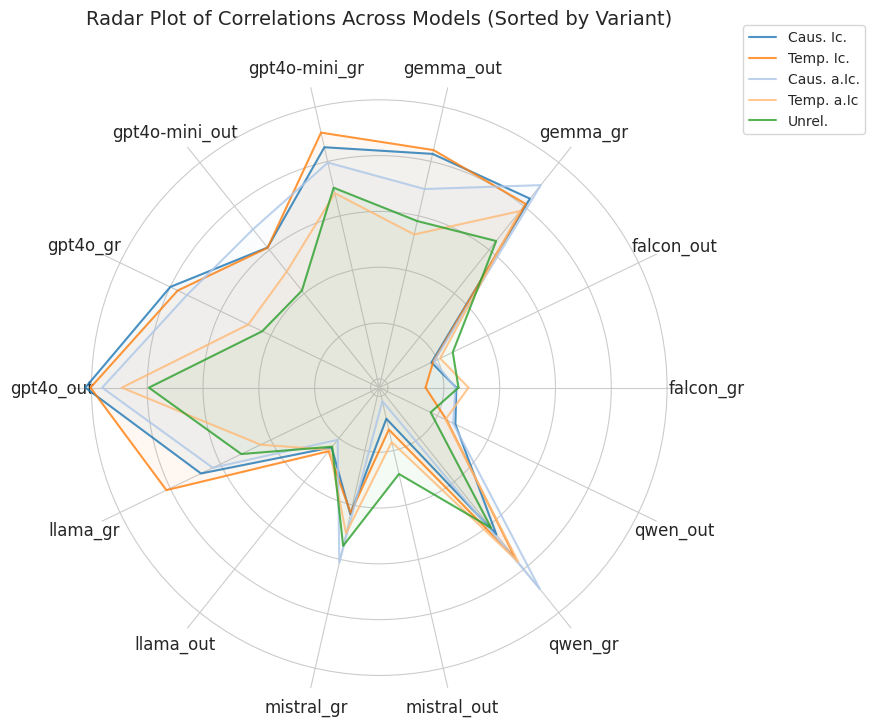

In [32]:
import numpy as np
import matplotlib.pyplot as plt
 
# Define models and categories
models = [
    "gpt4o_out", "gpt4o-mini_gr", "gemma_gr", "qwen_gr", "gemma_out", "llama_gr",
    "gpt4o_gr", "mistral_gr", "gpt4o-mini_out", "falcon_gr", "llama_out", "qwen_out",
    "falcon_out", "mistral_out"
]
 
categories = ["Caus. Ic.", "Temp. Ic.", "Caus. a.Ic.", "Temp. a.Ic", "Unrel."]
 
# Correlation data for each model-category pair
data = np.array([
    [0.822146, 0.803399, 0.761661, 0.691231, 0.594222],
    [0.652179, 0.705931, 0.595788, 0.483236, 0.503313],
    [0.634757, 0.610464, 0.696827, 0.578120, 0.440568],
    [0.441981, 0.549882, 0.690978, 0.567189, 0.411785],
    [0.627759, 0.641906, 0.498594, 0.331610, 0.380852],
    [0.477749, 0.615281, 0.430687, 0.240151, 0.317167],
    [0.599951, 0.570448, 0.533262, 0.289758, 0.234085],
    [0.234084, 0.228937, 0.411850, 0.304323, 0.350245],
    [0.410710, 0.409823, 0.494351, 0.300470, 0.213226],
    [0.044817, -0.065537, 0.041903, 0.088462, 0.052509],
    [0.042549, 0.060225, 0.007852, 0.053479, 0.039207],
    [0.071394, 0.037012, 0.062377, 0.032018, -0.026943],
    [-0.023770, -0.016544, -0.013441, 0.010723, 0.060977],
    [-0.116886, -0.077031, -0.181247, -0.031206, 0.086100]
])
 
# Sort models so that _gr variants come before _out variants for the same base model
model_base_names = [m.replace("_out", "").replace("_gr", "") for m in models]
sorted_indices = np.argsort([model_base_names[i] + ("a" if "_gr" in models[i] else "b") for i in range(len(models))])
 
# Apply sorting to models and data
sorted_models = [models[i] for i in sorted_indices]
sorted_data = data[sorted_indices]
 
# Recalculate angles based on sorted models
angles = np.linspace(0, 2 * np.pi, len(sorted_models), endpoint=False).tolist()
 
# Define colors for each category
colors = ["#1f77b4", "#ff7f0e", "#aec7e8", "#ffbb78", "#2ca02c"]
#colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]  # Blue, Orange, Green, Red, Purple
# Create radar chart with sorted models
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
 
for i, (category, color) in enumerate(zip(categories, colors)):
    values = sorted_data[:, i].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles + [angles[0]], values, label=category, alpha=0.8, color=color)
    ax.fill(angles + [angles[0]], values, alpha=0.05, color=color)
 
# Formatting
ax.set_xticks(angles)
ax.set_xticklabels(sorted_models, fontsize=12, ha="center")
 
# Remove the outer circle and y-axis labels
ax.spines["polar"].set_visible(False)
ax.set_yticklabels([])
 
# Title and legend formatting
ax.set_title("Radar Plot of Correlations Across Models (Sorted by Variant)", fontsize=14, pad=40)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=10)
 
plt.show()